# Setup

Let's import and initialize Spark, along with all the other libraries we're using (this might take a while).

In [2]:
# Uncomment these if do this homework locally
# Do not run this if you are on hive
# from local_install import setup_environment
# setup_environment()

import folium
import pyspark
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import os
%pylab inline
%pylab notebook

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [3]:
sc = pyspark.SparkContext()
sql = pyspark.sql.SQLContext(sc)

# 1. DataFrames

## 1a. File Format Wrangling

Implement the loading of data files into DataFrame objects.

### Begin Student Code Here

In [4]:
root_path = "/home/ff/cs186/sp16/fec_2016_3_25"

# file_struct objects
com_file = {'header': "cm_header_file.csv", 'data': "cm.txt" }
can_file = {'header': "cn_header_file.csv", 'data': "cn.txt" }
com_can_link_file = {'header': "ccl_header_file.csv", 'data': "ccl.txt" }
indv_file = {'header': "indiv_header_file.csv", 'data': "itcont.txt" }
pas_file = {'header': "pas2_header_file.csv", 'data': "itpas2.txt" }
com_links_file = {'header': "oth_header_file.csv", 'data': "itoth.txt" }

def load_header(filename):
    """
    Given a header .csv file, return a list containing the names of all columns in the table.
    
    Input:
    filename: a string specifying the header .csv file to load
    
    Output:
    A list containing column names of the table
    """
    with open(filename, "r") as f:
        return [r.replace('\r\n','') for r in f.readline().split(",")]
    
def load_dataframe(file_struct):
    """
    Given a dictionary representing the locations of FEC raw files corresponding to a table,
    load the tables into a Spark DataFrame.
    
    Input:
    file_struct: a dictionary containing the keys 'header' and 'data', where
     'header' contains the name of the `.csv` file specifying the table header file, and
     'data' contains the name of the `.txt` file specifying the table data file
     
    Output:
    A DataFrame which contains the loaded data.
    """
    # Get the name of the fields and make a sc of the data
    header_fields = load_header(root_path + "/" + file_struct['header'])
    lines = sc.textFile(root_path + "/" + file_struct['data'])
    
    # Convert each line into a tuple to get data fields
    data_fields = lines.map(lambda l: l.split("|"))
    
    # Make a StructField for each field, make a StructType for the schema using the resulting fields
    fields = [StructField(field_name, StringType(), True) for field_name in header_fields]
    schema = StructType(fields)
    
    # assign the data field schemes to a data frame
    df = sql.createDataFrame(data_fields, schema)
    
    return df.cache()

### End Student Code Here

We'll load these files into Spark now, and register them as temporary SQL tables.

In [5]:
com = load_dataframe(com_file)
can = load_dataframe(can_file)
links = load_dataframe(com_can_link_file)
indv = load_dataframe(indv_file)
pas = load_dataframe(pas_file)
com_links = load_dataframe(com_links_file)

In [6]:
com.registerTempTable("com")
can.registerTempTable("can")
links.registerTempTable("links")
indv.registerTempTable("indv")
pas.registerTempTable("pas")
com_links.registerTempTable("com_links")

## 1b. Basic Analytics Queries

As a demonstration, let's query for information corresponding to the strings "Clinton", "Sanders", "Trump", and "Cruz". Try these queries. How does this output look?

In [7]:
front_runners = can.where(can.CAND_NAME.like("%CLINTON%") | can.CAND_NAME.like("%SANDERS%") 
          | can.CAND_NAME.like("%TRUMP%") | can.CAND_NAME.like("%CRUZ%") )\
    .select("CAND_ID", "CAND_NAME", "CAND_STATUS", "CAND_OFFICE")
front_runners.show(truncate=False)

+---------+-----------------------------------+-----------+-----------+
|CAND_ID  |CAND_NAME                          |CAND_STATUS|CAND_OFFICE|
+---------+-----------------------------------+-----------+-----------+
|H2CA24153|THAYNE, DAVID CRUZ                 |P          |H          |
|H2MI08105|HETRICK, BRIAN CLINTON             |N          |H          |
|H2TX33123|SANDERS, KENNETH                   |P          |H          |
|H6NY05051|SANDERS, JAMES JR                  |C          |H          |
|H6NY09137|SANDERS, JAIME                     |N          |H          |
|H8OH02041|SANDERS, CHARLES W                 |P          |H          |
|P00003392|CLINTON, HILLARY RODHAM            |C          |P          |
|P60006111|CRUZ, RAFAEL EDWARD "TED"          |C          |P          |
|P60007168|SANDERS, BERNARD                   |C          |P          |
|P60012184|BALLSACK, DONALD TRUMP'S HAIRY KING|N          |P          |
|P60012333|CLINTON, BILL                      |N          |P    

In [8]:
front_runners = sql.sql("""
SELECT CAND_ID, CAND_NAME, CAND_STATUS, CAND_OFFICE
FROM can
WHERE CAND_NAME LIKE "%CLINTON%"
OR CAND_NAME LIKE "%SANDERS%"
OR CAND_NAME LIKE "%TRUMP%"
OR CAND_NAME LIKE "%CRUZ%"
""")
front_runners.registerTempTable("fr")
front_runners.show(truncate=False)

+---------+-----------------------------------+-----------+-----------+
|CAND_ID  |CAND_NAME                          |CAND_STATUS|CAND_OFFICE|
+---------+-----------------------------------+-----------+-----------+
|H2CA24153|THAYNE, DAVID CRUZ                 |P          |H          |
|H2MI08105|HETRICK, BRIAN CLINTON             |N          |H          |
|H2TX33123|SANDERS, KENNETH                   |P          |H          |
|H6NY05051|SANDERS, JAMES JR                  |C          |H          |
|H6NY09137|SANDERS, JAIME                     |N          |H          |
|H8OH02041|SANDERS, CHARLES W                 |P          |H          |
|P00003392|CLINTON, HILLARY RODHAM            |C          |P          |
|P60006111|CRUZ, RAFAEL EDWARD "TED"          |C          |P          |
|P60007168|SANDERS, BERNARD                   |C          |P          |
|P60012184|BALLSACK, DONALD TRUMP'S HAIRY KING|N          |P          |
|P60012333|CLINTON, BILL                      |N          |P    

That didn't work out so well. But notice how both queries got the same results! For the rest of the questions, you are allowed to write the queries in either form. Use the DataFrames that you created in part 1a. They are listed again here for reference:

* **com** contains committee information [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCommitteeMaster.shtml)
* **can** contains candidate information [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCandidateMaster.shtml)
* **links** contains linkage between committees and candidates [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCandCmteLinkage.shtml)
* **indv** contains individual contributions to committees [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionsbyIndividuals.shtml)
* **pas** contains contributions between committees [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionstoCandidates.shtml)
* **com_links** links between committees [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCommitteetoCommittee.shtml)

### Begin Student Code Here

Q1.

In [9]:
front_runners = sql.sql("""
SELECT CAND_ID, CAND_NAME, CAND_PCC
FROM can
WHERE (CAND_NAME LIKE "%CLINTON%"
OR CAND_NAME LIKE "%SANDERS%"
OR CAND_NAME LIKE "%TRUMP%"
OR CAND_NAME LIKE "%CRUZ%")
AND CAND_OFFICE = "P"
AND CAND_STATUS = "C"
""")
front_runners.registerTempTable("q1")
q1 = front_runners
q1.show(truncate=False)

+---------+-------------------------+---------+
|CAND_ID  |CAND_NAME                |CAND_PCC |
+---------+-------------------------+---------+
|P00003392|CLINTON, HILLARY RODHAM  |C00575795|
|P60006111|CRUZ, RAFAEL EDWARD "TED"|C00574624|
|P60007168|SANDERS, BERNARD         |C00577130|
|P80001571|TRUMP, DONALD J          |C00580100|
+---------+-------------------------+---------+



**Q1 Expected Output:**
```
+---------+-------------------------+---------+
|CAND_ID  |CAND_NAME                |CAND_PCC |
+---------+-------------------------+---------+
|P00003392|CLINTON, HILLARY RODHAM  |C00575795|
|P60006111|CRUZ, RAFAEL EDWARD "TED"|C00574624|
|P60007168|SANDERS, BERNARD         |C00577130|
|P80001571|TRUMP, DONALD J          |C00580100|
+---------+-------------------------+---------+
```

In [10]:
num_indv_contributions = sql.sql("""
SELECT a.CAND_ID, COUNT(TRANSACTION_AMT) AS count
FROM q1 AS a, indv AS b
WHERE b.CMTE_ID = a.CAND_PCC
GROUP BY a.CAND_ID
""")
num_indv_contributions.registerTempTable("temp1")

num_indv_contributions = sql.sql("""
SELECT a.CAND_ID, a.CAND_NAME, b.count
FROM q1 AS a, temp1 as b
WHERE a.CAND_ID = b.CAND_ID
""")

q2 = num_indv_contributions
q2.show(truncate=False)

+---------+-------------------------+-----+
|CAND_ID  |CAND_NAME                |count|
+---------+-------------------------+-----+
|P00003392|CLINTON, HILLARY RODHAM  |71249|
|P60006111|CRUZ, RAFAEL EDWARD "TED"|34699|
|P80001571|TRUMP, DONALD J          |3006 |
|P60007168|SANDERS, BERNARD         |34524|
+---------+-------------------------+-----+



**Q2 Expected Output:**
```
+---------+-------------------------+-----+
|CAND_ID  |CAND_NAME                |count|
+---------+-------------------------+-----+
|P80001571|TRUMP, DONALD J          |3006 |
|P60006111|CRUZ, RAFAEL EDWARD "TED"|34699|
|P60007168|SANDERS, BERNARD         |34524|
|P00003392|CLINTON, HILLARY RODHAM  |71249|
+---------+-------------------------+-----+
```

Q3.

In [11]:
indv_contributions_amt = sql.sql("""
SELECT a.CAND_ID, SUM(TRANSACTION_AMT) AS sum
FROM q1 AS a, indv AS b
WHERE b.CMTE_ID = a.CAND_PCC
GROUP BY a.CAND_ID
""")
indv_contributions_amt.registerTempTable("temp1")

indv_contributions_amt = sql.sql("""
SELECT a.CAND_ID, a.CAND_NAME, sum
FROM q1 AS a, temp1 as b
WHERE a.CAND_ID = b.CAND_ID
ORDER BY sum
""").withColumnRenamed("sum", "sum(TRANSACTION_AMT)")

# We will also accept a solution in either format.
# Be sure to comment out the one you don't use: 
q3 = indv_contributions_amt
q3.show(truncate=False)

+---------+-------------------------+--------------------+
|CAND_ID  |CAND_NAME                |sum(TRANSACTION_AMT)|
+---------+-------------------------+--------------------+
|P80001571|TRUMP, DONALD J          |1994976.0           |
|P60006111|CRUZ, RAFAEL EDWARD "TED"|2.4785175E7         |
|P60007168|SANDERS, BERNARD         |4.9001141E7         |
|P00003392|CLINTON, HILLARY RODHAM  |9.5996062E7         |
+---------+-------------------------+--------------------+



**Q3 Expected Output:**
```
+---------+-------------------------+--------------------+
|CAND_ID  |CAND_NAME                |sum(TRANSACTION_AMT)|
+---------+-------------------------+--------------------+
|P80001571|TRUMP, DONALD J          |1994976.0           |
|P60006111|CRUZ, RAFAEL EDWARD "TED"|2.4785175E7         |
|P60007168|SANDERS, BERNARD         |4.9001141E7         |
|P00003392|CLINTON, HILLARY RODHAM  |9.5996062E7         |
+---------+-------------------------+--------------------+
```

Q4.

In [12]:
linked_committees = sql.sql("""
SELECT a.CAND_NAME, a.CAND_ID, b.CMTE_ID, b.CMTE_NM
FROM q1 AS a, com AS b
WHERE a.CAND_ID = b.CAND_ID
""")
q4 = linked_committees.select("CAND_NAME", "CAND_ID", "CMTE_ID", "CMTE_NM")
q4.show(truncate=False)

+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CAND_NAME                |CAND_ID  |CMTE_ID  |CMTE_NM                                                                        |
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CLINTON, HILLARY RODHAM  |P00003392|C00570978|FUTURE OF AMERICAN LIVES MATTER                                                |
|CRUZ, RAFAEL EDWARD "TED"|P60006111|C00574624|CRUZ FOR PRESIDENT                                                             |
|CLINTON, HILLARY RODHAM  |P00003392|C00575795|HILLARY FOR AMERICA                                                            |
|SANDERS, BERNARD         |P60007168|C00577130|BERNIE 2016                                                                    |
|CLINTON, HILLARY RODHAM  |P00003392|C00577395|PEOPLE IN COMMAND/PIC                                    

**Q4 Expected Output:**
```
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CAND_NAME                |CAND_ID  |CMTE_ID  |CMTE_NM                                                                        |
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CLINTON, HILLARY RODHAM  |P00003392|C00577395|PEOPLE IN COMMAND/PIC                                                          |
|SANDERS, BERNARD         |P60007168|C00590646|NEW YORK CAPITAL REGION FOR BRINGING ECONOMIC REVOLUTION NOW INSPIRING EVERYONE|
|SANDERS, BERNARD         |P60007168|C00612549|LORAIN COUNTY FORWARD                                                          |
|CLINTON, HILLARY RODHAM  |P00003392|C00575795|HILLARY FOR AMERICA                                                            |
|SANDERS, BERNARD         |P60007168|C00587766|SILVER CITY NM FOR BERNIE SANDERS                                              |
|SANDERS, BERNARD         |P60007168|C00588707|ITHACA AND TOMPKINS COUNTY FOR BERNIE SANDERS                                  |
|SANDERS, BERNARD         |P60007168|C00589937|PROGRESSGJ                                                                     |
|SANDERS, BERNARD         |P60007168|C00588434|ROCHESTER FOR PROGRESS                                                         |
|SANDERS, BERNARD         |P60007168|C00577130|BERNIE 2016                                                                    |
|CRUZ, RAFAEL EDWARD "TED"|P60006111|C00574624|CRUZ FOR PRESIDENT                                                             |
|SANDERS, BERNARD         |P60007168|C00590828|UPPER VALLEY FOR BERNIE SANDERS                                                |
|CRUZ, RAFAEL EDWARD "TED"|P60006111|C00612119|CRUZ INFO PRESIDENT                                                            |
|SANDERS, BERNARD         |P60007168|C00583708|PROGRESS WV                                                                    |
|SANDERS, BERNARD         |P60007168|C00582395|UPSTATE NEW YORK FOR BERNIE SANDERS                                            |
|SANDERS, BERNARD         |P60007168|C00590620|LAS CRUCES FOR BERNIE                                                          |
|CLINTON, HILLARY RODHAM  |P00003392|C00570978|FUTURE OF AMERICAN LIVES MATTER                                                |
|TRUMP, DONALD J          |P80001571|C00580100|DONALD J. TRUMP FOR PRESIDENT, INC.                                            |
|SANDERS, BERNARD         |P60007168|C00590240|NORTHEAST MUSICIANS FOR SOCIAL DEMOCRACY                                       |
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
```

Q5.

In [13]:
num_com_contributions = sql.sql("""
SELECT CAND_ID, COUNT(*) AS count
FROM pas
GROUP BY CAND_ID
""")
num_com_contributions.registerTempTable("temp1")

num_com_contributions = sql.sql("""
SELECT a.CAND_NAME, b.count
FROM q1 AS a, temp1 AS b
WHERE a.CAND_ID = b.CAND_ID
""")

q5 = num_com_contributions
q5.show(truncate=False)

+-------------------------+-----+
|CAND_NAME                |count|
+-------------------------+-----+
|CLINTON, HILLARY RODHAM  |2561 |
|CRUZ, RAFAEL EDWARD "TED"|643  |
|TRUMP, DONALD J          |333  |
|SANDERS, BERNARD         |1577 |
+-------------------------+-----+



**Q5 Expected Output:**

```
+-------------------------+-----+
|CAND_NAME                |count|
+-------------------------+-----+
|CLINTON, HILLARY RODHAM  |2561 |
|SANDERS, BERNARD         |1577 |
|TRUMP, DONALD J          |333  |
|CRUZ, RAFAEL EDWARD "TED"|643  |
+-------------------------+-----+
```

Q6.

In [14]:
com_contributions_amt = sql.sql("""
SELECT CAND_ID, SUM(TRANSACTION_AMT) AS sum
FROM pas
GROUP BY CAND_ID
""")
com_contributions_amt.registerTempTable("temp1")

com_contributions_amt = sql.sql("""
SELECT a.CAND_NAME, b.sum
FROM q1 AS a, temp1 AS b
WHERE a.CAND_ID = b.CAND_ID
""").withColumnRenamed("sum", "sum(TRANSACTION_AMT)")

# We will also accept a solution in either format.
# Be sure to comment out the one you don't use: 
q6 = com_contributions_amt
q6.show(truncate=False)

+-------------------------+--------------------+
|CAND_NAME                |sum(TRANSACTION_AMT)|
+-------------------------+--------------------+
|CLINTON, HILLARY RODHAM  |6064499.0           |
|CRUZ, RAFAEL EDWARD "TED"|1.2145601E7         |
|TRUMP, DONALD J          |6099777.0           |
|SANDERS, BERNARD         |1202034.0           |
+-------------------------+--------------------+



**Q6 Expected Output:**

```
+-------------------------+--------------------+
|CAND_NAME                |sum(TRANSACTION_AMT)|
+-------------------------+--------------------+
|CLINTON, HILLARY RODHAM  |6064499.0           |
|SANDERS, BERNARD         |1202034.0           |
|TRUMP, DONALD J          |6099777.0           |
|CRUZ, RAFAEL EDWARD "TED"|1.2145601E7         |
+-------------------------+--------------------+
```

### End Student Code Here

# 2. K-means Clustering

## Use Dataframe API to load some Toy Data

Load a parquet file as a DataFrame.

In [15]:
df = sql.read.parquet("toy_data")

Let's look at a few records:

In [16]:
df.show()

+-----------+----------+
|          x|         y|
+-----------+----------+
| -4.5707927| -5.282721|
|  -5.762503| -4.832158|
|   7.907721|  6.793022|
|  7.4408655| -6.601918|
| -4.2428184| -4.162871|
| -5.7853255| -6.807544|
| -1.0236621| -8.026325|
|  7.2840943| 3.8668985|
|   8.975831| 3.7539392|
|  -7.442753|-5.6001735|
|-0.49966902| 5.3444986|
| -6.0518875|-5.4773846|
|  5.3814564| -4.115461|
| -5.9022512| 5.2586646|
| -3.1684203|-3.8134186|
| -6.7108235| 4.2055697|
|   2.811219| 3.8392153|
| -4.1118946| -6.137164|
|  5.8211355|-3.9361012|
|   8.003084|-3.3388462|
+-----------+----------+
only showing top 20 rows



## Plotting the Toy Data

We'll first plot a sample of some toy data. Let's collect a sample of records,

In [17]:
sample = df.sample(False, 0.2)

project out the `x` and the `y` columns,

In [18]:
x_sample = sample.select('x').collect()
y_sample = sample.select('y').collect()

and plot the data.

<IPython.core.display.Javascript object>


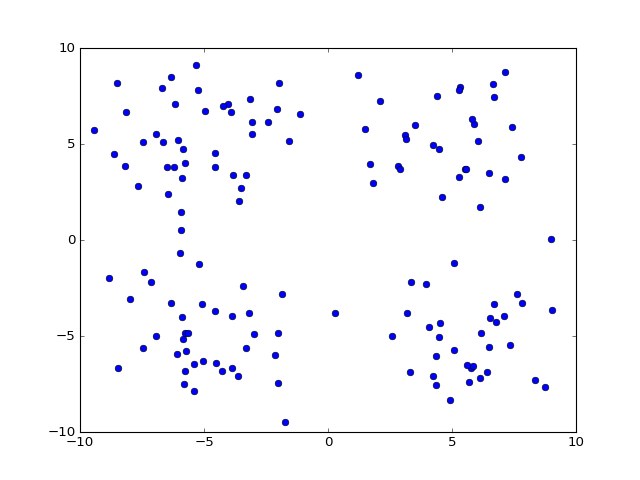

In [19]:
plt.figure()
plt.axis([-10, 10, -10, 10])
plot(x_sample, y_sample, 'bo')

## Implementation

Implement a distributed version of K-Means clustering using PySpark.

## 2a. K-Means++ Initialization

Initialize the centers using the K-Means++ Algorithm, using Distributed Reservoir Sampling. We've provided you the signatures of a few functions which may be helpful.

### Begin Student Code Here

In [83]:
def initialize_centers_plus(points, k):
    """
    Find k initial cluster centers using distributed weighted reservoir sampling.
    
    Inputs:
    points: a collection of d-dimensional points (x_1, x_2, ..., x_d).
    k: the number of cluster centers wanted
    
    Output:
    A list of k points which become the initial centers in K-means clustering
    """
    # Note during part 3, points is and rdd rather than a df so replace point with a map of itself
    points = points.map(lambda x: x) #returns rdd no matter if df or rdd
    
    # Choose first center uniformly at random note this returns a list
    centers = points.takeSample(True, 1)
    
    for _ in range(1, k):
        # Compute distances of each point to its nearest center
        # given distances, choose a new center
        
        # Get (point, weight) where weight is distance squared by mapping through nearest center then get map to 
        # get partition center then reduce by picking between centers
        result = points.map(lambda point: (point, nearest_center(centers, point)[1] ** 2)) \
            .mapPartitions(choose_partition_center)\
            .reduce(pick_between_centers)
        centers.append(result[0])
        
    return centers

In [84]:
def choose_partition_center(points_partition_iterator):
    """
    Choose a single center from a SINGLE PARTITION, using weighted random sampling.
    
    Inputs:
    points_partition_iterator: an iterator through a partition of D-dimensional points
    
    Output:
    (As an iterator) A 2-tuple, containing the randomly-chosen center and its weighted random-sampling key
    """
    center_key = []
    # Iterate through all the points and calculate its random-sampling key. 
    for point, weight in points_partition_iterator:
        # Get random value
        r = np.random.random()
        
        # Do not include weights with divisions by 0
        if weight == 0:
            center_key.append((point, 0))
        else:
            center_key.append((point, r ** (1.0/weight)))
    
    # Return the center with the highest random-sampling key
    
    # Try/catch used to catch partitions with no values 
    try:
        yield max(center_key, key = lambda x: x[1])
    except:
        pass

In [85]:
def pick_between_centers(candidate_center_1, candidate_center_2):
    """
    Between two centers from different partitions, pick the one with a larger key.
    
    Inputs:
    candidate_center_1: a 2-tuple, containing the randomly-chosen center and its weighted random sampling key 
                        from the first partition
    candidate_center_2: a 2-tuple, containing the randomly-chosen center and its weighted random sampling key 
                        from the first partition
    
    Output:
    A 2-tuple, containing the "better" center and its weighted random-sampling key
    """
    # If candidate 1 key is greater than candidate 2's key, return candidate 1's center
    if candidate_center_1[1] > candidate_center_2[1]:
        return candidate_center_1
    # Otherwise if candidate 2's key is greater, or both key's are equal, return candidate 2's center
    else:
        return candidate_center_2

In [86]:
def nearest_center(centers, point):
    """
    Given a point and a list of centers (also points), determine the center closest to that point,
    and compute the distance to that point.
    
    Inputs:
    centers: a list of points which represent the current centers
    point: the point to examine
    
    Outputs:
    A 2-tuple, containing the index of the closest center (point) and its distance from point
    """
    #Make sure point passed is not none test
    try:
    
        centers_arr = np.asarray(centers)

        # Get distances from centers to a specific point
        distances = np.linalg.norm(centers_arr - point, axis=1)

        # Get the minimum distance and get the center index of the one with minimum distance
        index = np.argmin(distances)
        shortest_distance = distances[index]
        
        return (index, shortest_distance)
    except:
        return None

### End Student Code Here

## Plotting the centers

Let's see how our initialization algorithm performs. How do your centers look? Are they too close to each other?

[Row(x=-4.5707926750183105, y=-5.282721042633057), Row(x=4.63060998916626, y=4.864567756652832), Row(x=7.293618202209473, y=-8.756925582885742), Row(x=-4.500964641571045, y=4.520628929138184)]


<IPython.core.display.Javascript object>


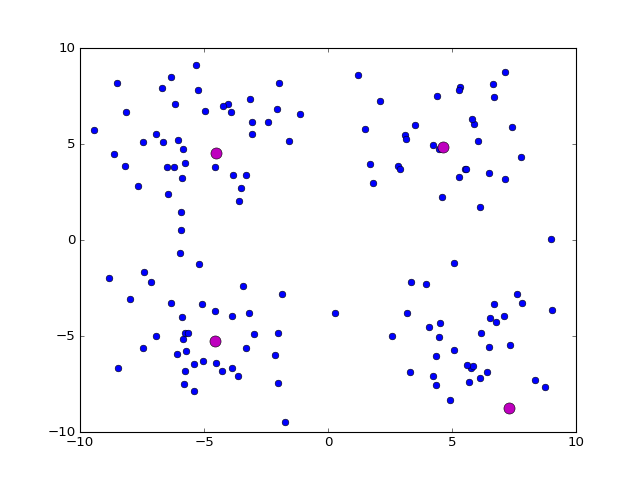

In [87]:
num_centers = 4
centers = initialize_centers_plus(df, num_centers)
print centers 
plt.figure()
plt.axis([-10, 10, -10, 10])
plot(x_sample, y_sample, 'bo')
centers = np.asarray(centers)
plt.plot(centers[:,0], centers[:,1], 'mo', markersize = 10)

## 2b. Main Loop

Now, implement the main loop in K-means clustering. Again, we've provided you the signatures of some functions which may be useful.

Note: The statistics of a new center "mean" is given by:
$$
\bar{x}_k = \frac{1}{n_k} \sum_{x \in \text{Cluster}[k]}^{n_i} x
$$
So the only statistics we require are $n_k$ the number of elements in cluster $k$ and $\sum_{x \in \text{Cluster}[k]}^{n_i} x$ the sum of the elements in cluster $k$.

### Begin Student Code Here

In [88]:
def k_means(points,
            k = num_centers,
            initial_centers = None,
            max_iterations = 100,
            initializer = initialize_centers_plus,
            epsilon = 0.001):
    """
    Executes the K-means algorithm on a collection of points.
    
    Inputs:
    points: a collection of d-dimensional points (x_1, x_2, ..., x_d).
    k: the number of cluster centers wanted
    initial_centers: if supplied, skips the initialization phase and uses points from this value
    max_iterations: the maximum number of main-loop iterations to run
    initializer: a function which selects initial centers (if none supplied)
    epsilon: the threshhold at which convergence is reached and the algorithm halted
    
    Output:
    A list of k candidate cluster centers
    """
    points.map(lambda x: x)
    
    # speeds up rerunning
    points.cache()
        
    old_centers = None
    new_centers = None
    if initial_centers: # we were provided initial centers to use
        new_centers = initial_centers
    else: # we need to initialize the centers ourselves
        new_centers = initializer(points, k) #initializer_points has to be dataframe

    iteration = 0
    while not has_converged(old_centers, new_centers, epsilon) and iteration < max_iterations:
        # update centers
        old_centers = new_centers
        new_centers = [np.zeros(len(old_centers[0])) for i in range(k)]
        
        # Compute new center statistics on each partition with map, then reduce by adding
        # the statistics together. Use the resulting tuple to generate the new centers
        # for the graph by iterating through k and computing sums[i]/counts[i], keep
        # going until old and new centers are the same (converge) or max iterations happens
        stats = points.mapPartitions(lambda iterate: compute_new_center_statistics(iterate, old_centers))\
            .reduce(add_statistics)
            
        # Compute centers
        for i in range(k):
            new_centers[i] = stats[1][i]/stats[0][i]

        iteration += 1
        
    return new_centers

In [89]:
def compute_new_center_statistics(iterator, old_centers):
    """
    Given an iterator over points and a list of old centers, compute the statistics for the new center.
    
    Input:
    iterator: an iterator over points
    old_centers: a list of centers (points) from the previous iteration
    
    Output:
    A 2-tuple (counts, sums) consisting of:
     - counts: an array of length k containing the count of points in each new center
     - sums: a k by d array consisting of sum of the points assigned to each center
     
    Note that from the tuple you could compute the ith new center:
      sums[i] / counts[i]
    """
    # Get the shape of the old centers, shape is dimensions 
    k, d = np.asarray(old_centers).shape
    
    # Initialize the sums
    counts = np.zeros(k)
    sums = np.zeros((k, d))
    
    # Loop over the data and compute the new assignments
    for point in iterator:
        # Compute the nearest center (you just implemented this!)
        # Returns index of closest center, and its distance tuple
        index, distance = nearest_center(old_centers, point)
        
        # Update the sums and counts
        counts[index] += 1
        sums[index] += point

    yield (counts, sums)

In [90]:
def add_statistics(stats_1, stats_2):
    """
    Given statistics from two partitions, add those statistics.
    """
    # Compute stats_1 + stats_2
    stats = (stats_1[0] + stats_2[0], stats_1[1] + stats_2[1])
    
    return stats

### End Student Code Here

In [91]:
def has_converged(old_centers, new_centers, epsilon):
    """
    Test if the distance between the centers is less than epsilon.
    """
    return (old_centers is not None) and (new_centers is not None) and \
        np.linalg.norm(np.asarray(old_centers) - np.asarray(new_centers), ord=2) < epsilon

## Plotting Clusters

How does your code perform? Are these good clusters?

In [92]:
colors = ['ro', 'bo', 'go', 'yo'] # for now just use 4 colors

def plot_clusters(centers, plt):
    for i in range(num_centers):
        cluster = df.rdd.filter(lambda x: nearest_center(centers, x)[0] == i)
        cluster_sample = np.asarray(cluster.sample(False, 0.2).collect())
        plt.plot(cluster_sample[:,0], cluster_sample[:,1], colors[i])
    

<IPython.core.display.Javascript object>


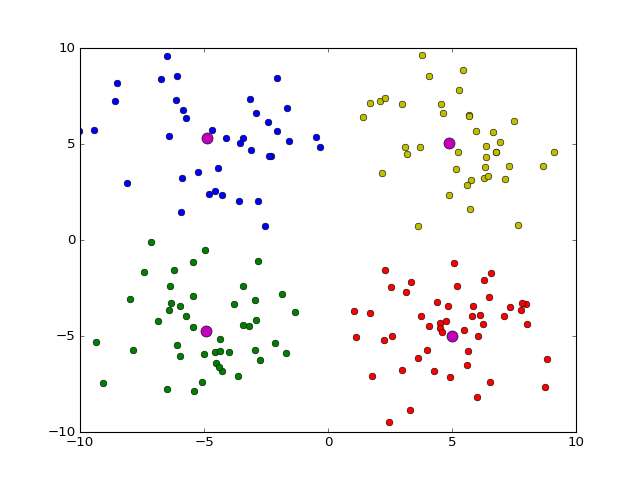

In [93]:
plt.figure()
plt.axis([-10, 10, -10, 10])

centers = k_means(df, num_centers)
plot_clusters(centers, plt)

centers = np.asarray(centers)
plt.plot(centers[:,0], centers[:,1], 'mo', markersize = 10)


# 3. Geographical Contribution Clustering

Let's put everything together! First we'll load the required data files.

In [94]:
zip_codes = sql.read.parquet("zip_codes")

Now we'll grab the relevant data we need. We'll join the table of front runners we collected earlier with their contributors' zip codes to get latitudinal and longitudinal data...

In [95]:
contrib_zips = \
    front_runners.join(indv, front_runners.CAND_PCC == indv.CMTE_ID) \
    .select("CAND_NAME", "CAND_ID", "ZIP_CODE")
contrib_zips = contrib_zips.withColumn("SHORT_ZIP", contrib_zips.ZIP_CODE.substr(0,5))

In [96]:
contrib_locs = \
    contrib_zips.join(zip_codes, contrib_zips.SHORT_ZIP == zip_codes.zip) \
    .select("CAND_NAME", "latitude", "longitude").cache()

In [97]:
candidate_names = [x[0] for x in contrib_locs.select("CAND_NAME").distinct().collect()]
candidate_names

[u'CLINTON, HILLARY RODHAM',
 u'SANDERS, BERNARD',
 u'TRUMP, DONALD J',
 u'CRUZ, RAFAEL EDWARD "TED"']

In [98]:
X = {}
for candidate in candidate_names:
    X[candidate] = contrib_locs.where(contrib_locs.CAND_NAME == candidate) \
        .select("latitude", "longitude") \
        .map(lambda r: np.array([x for x in r])) \
        .coalesce(sc.defaultParallelism).cache()

...which will allow us to plot these locations.

In [99]:
maps = {}
for candidate in X:
    maps[candidate] = folium.Map(location=[40, -100],
           tiles='Stamen Toner',
           zoom_start=4)
    locs = X[candidate].sample(False, 0.01).collect()
    for l in locs:
        folium.Marker(l).add_to(maps[candidate])

In [100]:
maps[u'CRUZ, RAFAEL EDWARD "TED"']

We can run k-means for each candidate. What's a good value for $k$? Run the K-means algorithm you developed earlier with different values of $k$ to determine the best one.

### Begin Student Code Here

In [101]:
def compute_errors(candidate_locations, k_range):
    def reduction(a, b):
        try:
            return a + b
        except:
            if a is None:
                return b
            elif b is None:
                return a
        
    errors = {}
    for c in candidate_locations:
        errors[c] = []
        for k in k_range:
            # For each candidate, test multiple values of k
            
            # Get centers for each candidate for each k, note that X[c] is the rdd of points 
            # for a candidate
            centers = k_means(candidate_locations[c], k)
            
            # Calculate the error, which is the mean of the distances from the points to their cluster centers
            #note some partitions might be empty
            overall_sum = candidate_locations[c].map(lambda x: nearest_center(centers, x)[1]).reduce(reduction)
            error = overall_sum/candidate_locations[c].count()
            
            errors[c].append(error)
    return errors

<IPython.core.display.Javascript object>


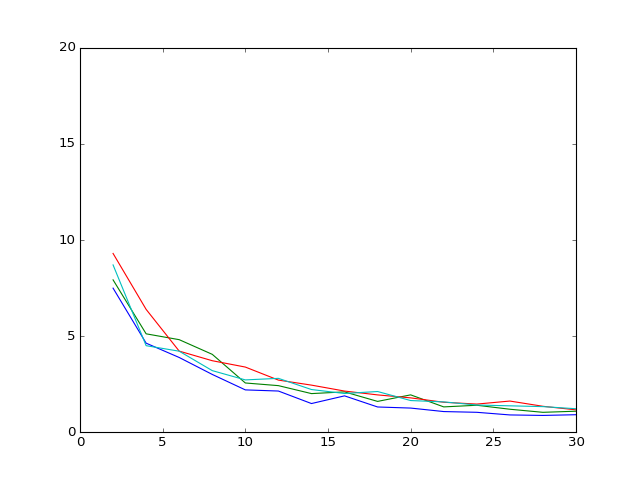

In [102]:
plt.figure()
plt.axis([0, 30, 0, 20])
k_range = range(2, 32, 2) #change back to 32
errors = compute_errors(X, k_range)

for c in errors:
    plot(k_range, errors[c])

Now that you've found a suitable value for k, run K-means to compute the desired clusters.

In [57]:
centers = {}
k = 10 
for c in X:
    # Find the cluster centers for each candidate
    centers[c] = k_means(X[c], k)

### End Student Code Here

At last, we have the clusters we want. Here's a nifty visualization.

In [ ]:
colors = dict(zip(centers.keys(), ['blue', 'green','orange', 'red']))
centers_map = folium.Map(location=[40, -100],
                         zoom_start=4)
for candidate in centers: 
    locs = centers[candidate]
    for l in locs:
        folium.Marker(l,
                      popup=str(l),
                      icon=folium.Icon(color=colors[candidate])).add_to(centers_map)
centers_map

Congratulations! You've successfully implemented a scalable machine learning algorithm on dataset of campaign finance contributions!